In [1]:
# %pip install odc-stac

In [2]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Import common GIS tools
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray as rio
import rasterio
from rasterio.features import rasterize
from matplotlib.cm import RdYlGn,jet,RdBu
import geopandas as gpd
from shapely import wkt
from shapely.geometry import mapping, box
from shapely.ops import unary_union, transform
from pyproj import Proj, Transformer

# Import Planetary Computer tools
import stackstac
import pystac_client
import planetary_computer 
from odc.stac import stac_load

# Others
from tqdm import tqdm

### Discover and load the data for analysis

First, we define our area of interest using latitude and longitude coordinates. 

In [3]:
# Define the bounding box for the entire data region using (Latitude, Longitude)
# This is the region of New York City that contains our temperature dataset
lower_left = (40.75, -74.01)
upper_right = (40.88, -73.86)

In [4]:
# Calculate the bounds for doing an archive data search
# bounds = (min_lon, min_lat, max_lon, max_lat)
bounds = (lower_left[1], lower_left[0], upper_right[1], upper_right[0])

In [5]:
# Define the time window
time_window = "2021-06-01/2021-09-01"

In [6]:
# Define the pixel resolution for the final product
# Define the scale according to our selected crs, so we will use degrees
resolution = 10  # meters per pixel 
scale = resolution / 111320.0 # degrees per pixel for crs=4326 

Using the `pystac_client` we can search the Planetary Computer's STAC endpoint for items matching our query parameters. We will use a period of 3 months as a representative dataset for the region. The query searches for "low cloud" scenes with overall cloud cover <30%. The result is the number of scenes matching our search criteria that touch our area of interest. Some of these may be partial scenes or contain clouds.

#### Sentinel data

In [7]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = stac.search(
    bbox=bounds, 
    datetime=time_window,
    collections=["sentinel-2-l2a"],
    query={"eo:cloud_cover": {"lt": 30}},
)

In [8]:
items = list(search.get_items())
print('This is the number of scenes that touch our region:',len(items))
items

This is the number of scenes that touch our region: 10


[<Item id=S2A_MSIL2A_20210813T154911_R054_T18TWL_20210814T063950>,
 <Item id=S2A_MSIL2A_20210731T153911_R011_T18TWL_20210801T071615>,
 <Item id=S2A_MSIL2A_20210724T154911_R054_T18TWL_20210725T064752>,
 <Item id=S2B_MSIL2A_20210716T153809_R011_T18TWL_20210717T091632>,
 <Item id=S2A_MSIL2A_20210714T154911_R054_T18TWL_20210715T061637>,
 <Item id=S2B_MSIL2A_20210706T153809_R011_T18TWL_20210713T062155>,
 <Item id=S2B_MSIL2A_20210629T154809_R054_T18TWL_20210630T180646>,
 <Item id=S2A_MSIL2A_20210624T154911_R054_T18TWL_20210625T202950>,
 <Item id=S2B_MSIL2A_20210616T153809_R011_T18TWL_20210617T042622>,
 <Item id=S2B_MSIL2A_20210606T153809_R011_T18TWL_20210609T213133>]

Next, we'll load the data into an [xarray](https://xarray.pydata.org/en/stable/) DataArray using [stackstac](https://stackstac.readthedocs.io/). We will only keep the commonly used spectral bands (Red, Green, Blue, NIR, SWIR). There are also several other <b>important settings for the data</b>: We have changed the projection to epsg=4326 which is standard latitude-longitude in degrees. We have specified the spatial resolution of each pixel to be 10-meters. 

In [12]:
signed_items = [planetary_computer.sign(item).to_dict() for item in items]
signed_items

[{'type': 'Feature',
  'stac_version': '1.1.0',
  'stac_extensions': ['https://stac-extensions.github.io/eo/v1.0.0/schema.json',
   'https://stac-extensions.github.io/sat/v1.0.0/schema.json',
   'https://stac-extensions.github.io/projection/v1.0.0/schema.json'],
  'id': 'S2A_MSIL2A_20210813T154911_R054_T18TWL_20210814T063950',
  'geometry': {'type': 'Polygon',
   'coordinates': [[[-73.69702, 40.87646388],
     [-73.71323, 40.83204295],
     [-73.76651, 40.68576838],
     [-73.81354, 40.55609129],
     [-75.000244, 40.56274991],
     [-75.000244, 41.55184467],
     [-73.68381, 41.54431154],
     [-73.69702, 40.87646388]]]},
  'bbox': [-75.000244, 40.55609128855379, -73.68381, 41.551844670066835],
  'properties': {'datetime': '2021-08-13T15:49:11.024000Z',
   'platform': 'Sentinel-2A',
   'proj:epsg': 32618,
   'instruments': ['msi'],
   's2:mgrs_tile': '18TWL',
   'constellation': 'Sentinel 2',
   's2:granule_id': 'S2A_OPER_MSI_L2A_TL_ESRI_20210814T063951_A032083_T18TWL_N03.00',
   'eo:

##### Sentinel-2 Bands Summary 
The following list of common bands can be loaded by the Open Data Cube (ODC) stac command.<br><br>
B01 = Coastal Aerosol = 60m <br>
B02 = Blue = 10m <br>
B03 = Green = 10m <br>
B04 = Red = 10m <br>
B05 = Red Edge (704 nm) = 20m <br>
B06 = Red Edge (740 nm) = 20m <br>
B07 = Red Edge (780 nm) = 20m <br>
B08 = NIR (833 nm) = 10m <br>
B8A = NIR (narrow 864 nm) = 20m <br>
B11 = SWIR (1.6 um) = 20m <br>
B12 = SWIR (2.2 um) = 20m

In [10]:
data = stac_load(
    items,
    bands=["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"],
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=planetary_computer.sign,
    bbox=bounds
)

ValueError: The asset must have the following fields (from the projection extension): shape, transform, and one of an epsg, wkt2, or projjson

##### View RGB (real color) images from the time series
You will notice that some of the scenes have clouds. You may want to use a scene from a single date, or create a median mosaic using all of the data in the time series. Also, these images are merely for quick review and are not scaled correctly to reflect the proper Lat-Lon ratios. Finally, the numbering for these scenes starts at ZERO and goes from the top-left across the rows to reach the total number of scenes in the data array shown above. 

In [10]:
# Plot sample images from the time series
plot_data = data[["B04","B03","B02"]].to_array()
plot_data.plot.imshow(col='time', col_wrap=4, robust=True, vmin=0, vmax=2500)
plt.show()

NameError: name 'data' is not defined

NameError: name 'plot_data' is not defined

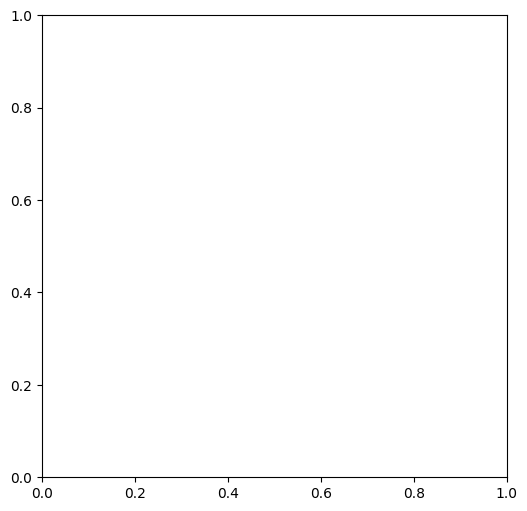

In [ ]:
# Plot an RGB image for a single date
fig, ax = plt.subplots(figsize=(6,6))
plot_data.isel(time=7).plot.imshow(robust=True, ax=ax, vmin=0, vmax=2500)
ax.set_title("RGB Single Date: July 24, 2021")
ax.axis('off')
plt.show()

##### Median composite

Using normal xarray operations, we can [compute the median](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.median.html) over the time dimension. Under the assumption that clouds are not common (<30% per scene) and in random locations, the composite shouldn't contain (many) clouds, since they shouldn't be the median pixel value at that point over many images. 

In [14]:
median = data.median(dim="time").compute()

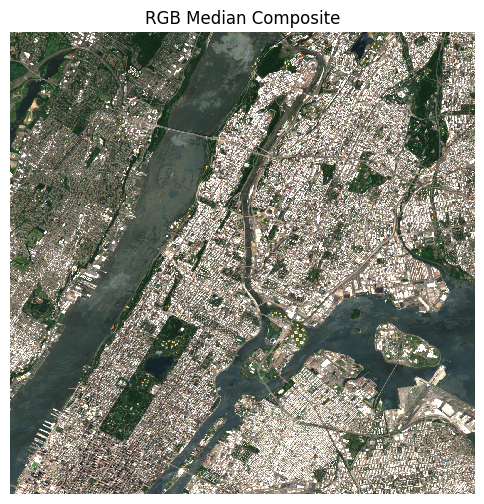

In [19]:
# Plot an RGB image for the median composite or mosaic
# Notice how this new image is void of clouds due to statistical filtering
fig, ax = plt.subplots(figsize=(6,6))
median[["B04", "B03", "B02"]].to_array().plot.imshow(robust=True, ax=ax, vmin=0, vmax=2500)
ax.set_title("RGB Median Composite")
ax.axis('off')
plt.show()

##### Save the output data in a GeoTIFF file
We have selected a single date (July 24, 2021) to create a GeoTIFF output product. This date is the same as the ground temperature data collection date. Though this image contains some clouds, it will be used as the baseline for the benchmark notebook. Participants in the data challenge may desire to use other single scenes with less cloud cover or create a median mosaic that statistically filters the clouds over a time series stack of data (see the median dataset above).
<br><br>The output product below only contains 4 selected bands that are used in the benchmark notebook. Participants may choose to include all of the bands for their models to investigate how different bands and derived spectral indices change their model results. 

In [15]:
filename = "features_test/sentinel2.tiff"
height = median.dims["latitude"]
width = median.dims["longitude"]

gt = rasterio.transform.from_bounds(lower_left[1], lower_left[0], upper_right[1], upper_right[0], width, height)
median.rio.write_crs("epsg:4326", inplace=True)
median.rio.write_transform(transform=gt, inplace=True)

<xarray.Dataset> Size: 213MB
Dimensions:      (latitude: 1448, longitude: 1671)
Coordinates:
  * latitude     (latitude) float64 12kB 40.88 40.88 40.88 ... 40.75 40.75 40.75
  * longitude    (longitude) float64 13kB -74.01 -74.01 -74.01 ... -73.86 -73.86
    spatial_ref  int64 8B 0
Data variables:
    B01          (latitude, longitude) float64 19MB 713.5 713.5 ... 1.212e+03
    B02          (latitude, longitude) float64 19MB 703.0 703.0 ... 1.343e+03
    B03          (latitude, longitude) float64 19MB 848.0 848.0 ... 1.452e+03
    B04          (latitude, longitude) float64 19MB 850.0 850.0 ... 1.535e+03
    B05          (latitude, longitude) float64 19MB 1.06e+03 ... 1.639e+03
    B06          (latitude, longitude) float64 19MB 2.084e+03 ... 1.716e+03
    B07          (latitude, longitude) float64 19MB 2.321e+03 ... 1.834e+03
    B08          (latitude, longitude) float64 19MB 2.02e+03 ... 1.835e+03
    B8A          (latitude, longitude) float64 19MB 2.613e+03 ... 1.912e+03
    B11          (latitude, longitude) float64 19MB 1.778e+03 ... 2.14e+03
    B12          (latitude, longitude) float64 19MB 1.198e+03 ... 1.986e+03

In [22]:
# Create the GeoTIFF output file using the defined parameters 
with rasterio.open(filename,'w',driver='GTiff',width=width,height=height,
                   crs='epsg:4326',transform=gt,count=11,compress='lzw',dtype='float64') as dst:
    dst.write(median.B01,1)
    dst.write(median.B02,2)
    dst.write(median.B03,3)
    dst.write(median.B04,4)
    dst.write(median.B05,5)
    dst.write(median.B06,6)
    dst.write(median.B07,7) 
    dst.write(median.B08,8)
    dst.write(median.B8A,9)
    dst.write(median.B11,10)
    dst.write(median.B12,11)
    dst.close()

### Building

##### Building areas within a pixel

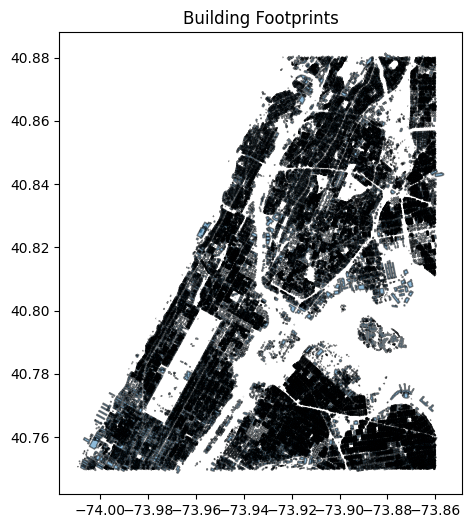

In [6]:
building = pd.read_csv("Building_Footprints_20250129.csv")
building['the_geom'] = building['the_geom'].apply(wkt.loads)
gdf_build = gpd.GeoDataFrame(building, geometry="the_geom", crs="EPSG:4326")

gdf_build = gdf_build.cx[lower_left[1]:upper_right[1], lower_left[0]:upper_right[0]]
gdf_build.plot(figsize=(6, 6), edgecolor="black", alpha=0.5)
plt.title("Building Footprints")
plt.show()

In [17]:
gdf_build = gdf_build.to_crs(epsg=2263)
gdf_build['SHAPE_AREA'] = gdf_build['the_geom'].area

In [38]:
gdf_build[gdf_build.duplicated(subset=['NAME','BIN', 'CNSTRCT_YR', 'LSTMODDATE', 'LSTSTATYPE	DOITT_ID	HEIGHTROOF	FEAT_CODE	GROUNDELEV	SHAPE_AREA	SHAPE_LEN	BASE_BBL	MPLUTO_BBL'])]

Empty GeoDataFrame
Columns: [the_geom, NAME, BIN, CNSTRCT_YR, LSTMODDATE, LSTSTATYPE, DOITT_ID, HEIGHTROOF, FEAT_CODE, GROUNDELEV, SHAPE_AREA, SHAPE_LEN, BASE_BBL, MPLUTO_BBL, GEOMSOURCE, GLOBALID]
Index: []

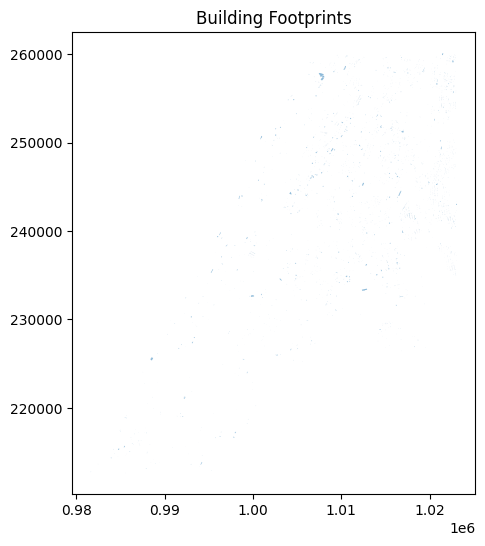

In [40]:
data = gdf_build[(gdf_build['BIN'] // 10**6).isin([1, 2]) & (gdf_build['HEIGHTROOF'] < 12)]
data.plot(figsize=(6, 6), alpha=0.5)
plt.title("Building Footprints")
plt.show()

In [41]:
data['FEAT_CODE'].value_counts()

FEAT_CODE
5110    2337
2100     762
1000      42
1004      25
1003       4
1001       4
5100       4
2110       2
1005       1
Name: count, dtype: int64

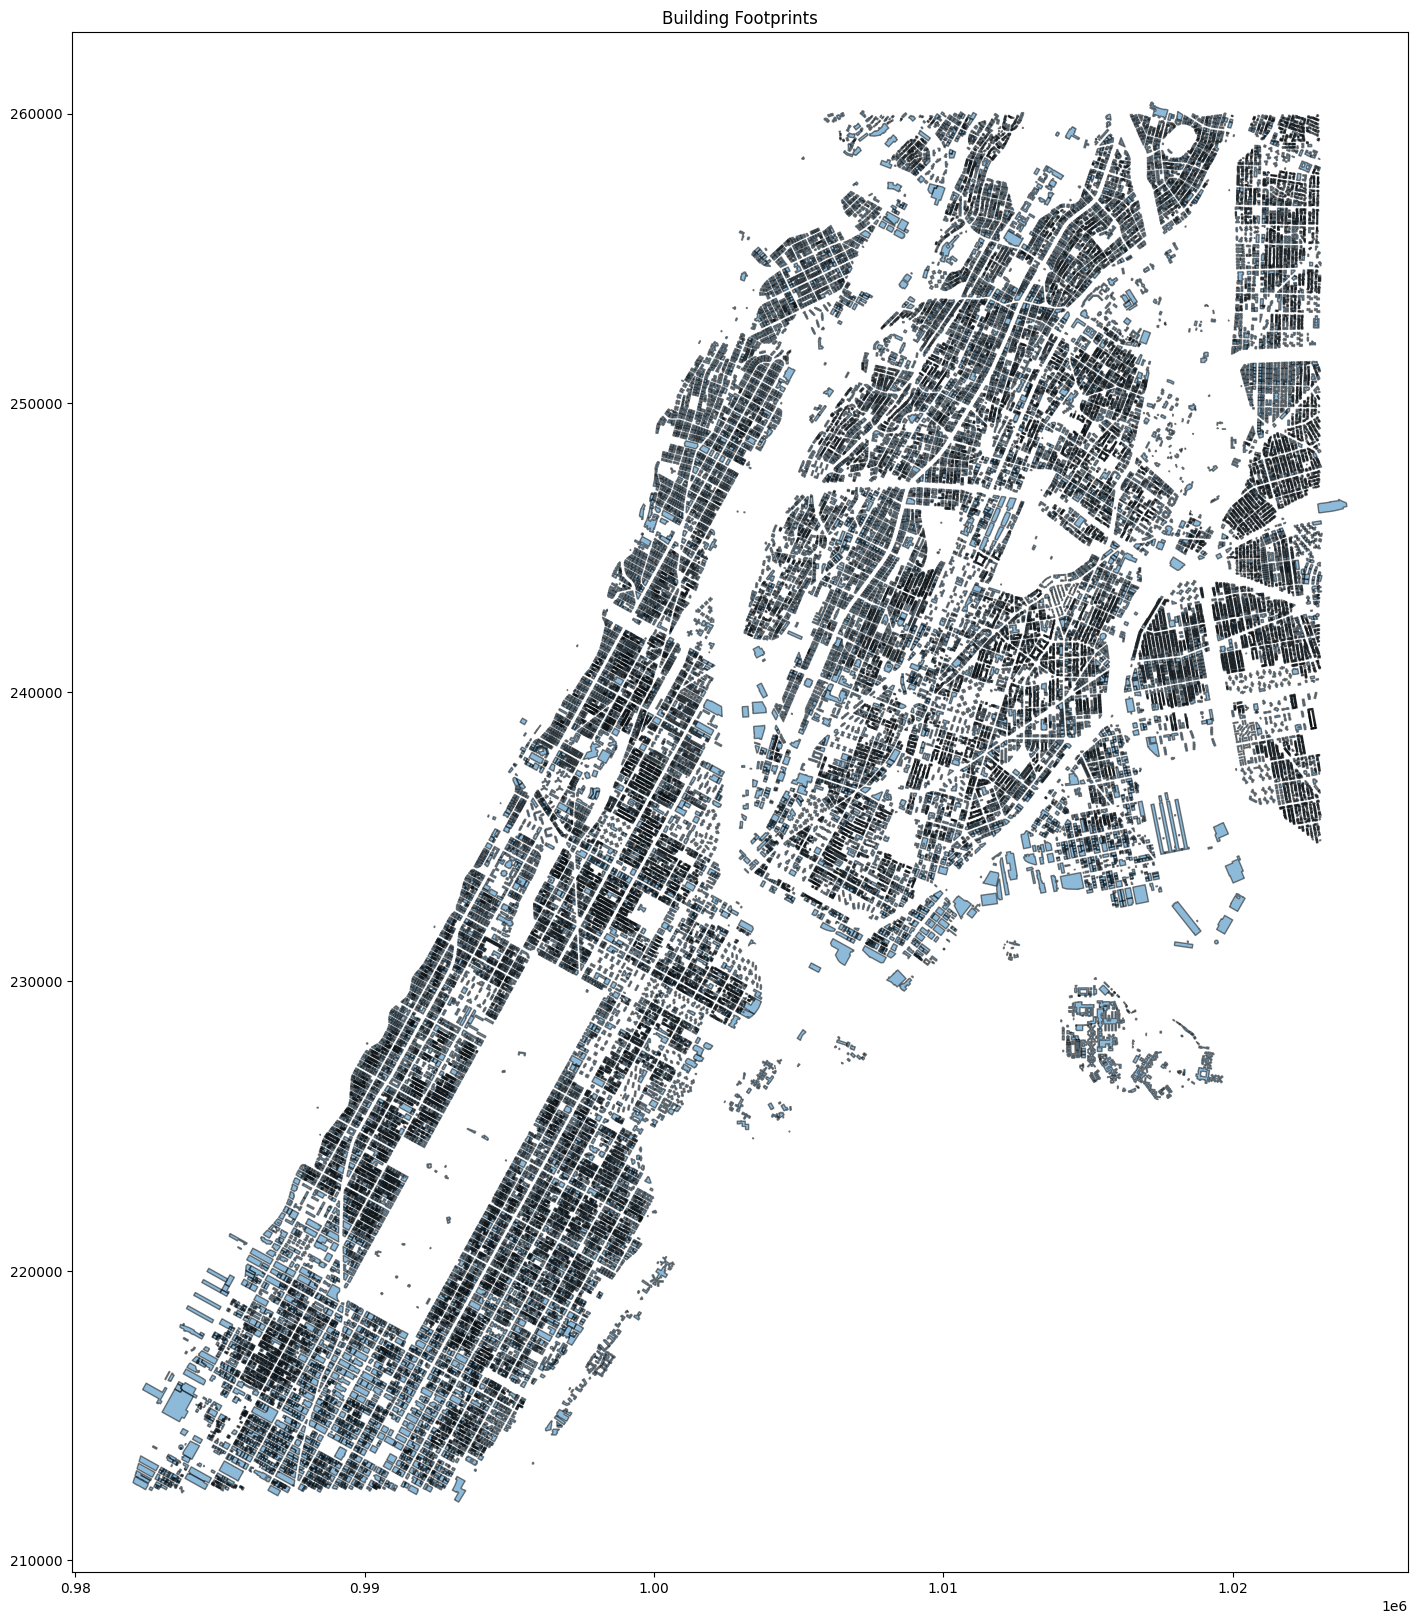

In [117]:
## Obtain buildings existing in 2021

mod_date = pd.to_datetime(gdf_build['LSTMODDATE'])
build_cond = (gdf_build['CNSTRCT_YR'] <= 2021) \
    & (gdf_build['BIN'] // 10**6).isin([1, 2]) \
    & (gdf_build['HEIGHTROOF'] >= 12) \
    & (gdf_build['SHAPE_AREA'] >= 400) \
    & (gdf_build['FEAT_CODE'].isin([1006, 2100])) \
    & ((mod_date < '2021-07-24') & (gdf_build['LSTSTATYPE'].isin(['Constructed'])))

gdf_build_filter = gdf_build[build_cond].reset_index()
gdf_build_filter.plot(figsize=(20, 20), edgecolor="black", alpha=0.5)
plt.title("Building Footprints")
plt.show()

In [46]:
gdf_build_filter = gdf_build_filter.reset_index()

for idx, building in tqdm(gdf_build_filter.iterrows()):
    building_geometry = building['the_geom']
    for jdx, other_building in gdf_build_filter.iterrows():
        if idx != jdx:  # Avoid comparing the building with itself
            other_building_geometry = other_building['the_geom']
            # Step 4: Check if they intersect
            if building_geometry.intersects(other_building_geometry):
                print(idx, ", ", jdx)

0it [00:00, ?it/s]

0 ,  23587
0 ,  47765


1it [00:05,  5.83s/it]

1 ,  47725


2it [00:10,  4.95s/it]

2 ,  211
2 ,  37455


4it [00:18,  4.51s/it]

4 ,  35083
4 ,  44342


5it [00:23,  4.54s/it]

5 ,  12792
5 ,  32840


6it [00:28,  4.65s/it]

6 ,  30412
6 ,  39177


7it [00:33,  4.84s/it]

7 ,  6357
7 ,  48357


8it [00:38,  4.82s/it]

8 ,  22350


9it [00:42,  4.68s/it]

9 ,  1554


10it [00:46,  4.53s/it]

10 ,  9240
10 ,  44478


11it [00:51,  4.49s/it]

11 ,  12579
11 ,  32988


13it [01:00,  4.43s/it]

13 ,  48851


16it [01:14,  4.75s/it]

16 ,  10570
16 ,  47298


17it [01:20,  5.29s/it]

17 ,  26083


18it [01:27,  5.67s/it]

18 ,  6678
18 ,  9379


19it [01:34,  6.03s/it]

19 ,  11800
19 ,  20487


20it [01:39,  5.89s/it]

20 ,  35239


21it [01:44,  5.51s/it]

21 ,  3046
21 ,  22226
21 ,  33793


23it [01:53,  4.96s/it]

23 ,  25051


24it [01:57,  4.78s/it]

24 ,  31936
24 ,  42690


25it [02:02,  4.71s/it]

25 ,  18913
25 ,  31712


26it [02:06,  4.61s/it]

26 ,  43572


27it [02:10,  4.51s/it]

27 ,  36703


28it [02:15,  4.40s/it]

28 ,  724
28 ,  53707


29it [02:19,  4.39s/it]

29 ,  2025


30it [02:23,  4.37s/it]

30 ,  7493


32it [02:34,  4.95s/it]

32 ,  33297


33it [02:42,  5.72s/it]

32 ,  59636
33 ,  25754


34it [02:49,  6.24s/it]

34 ,  3388
34 ,  41538


36it [03:04,  6.98s/it]

36 ,  47821


37it [03:13,  7.31s/it]

37 ,  48267


38it [03:21,  7.56s/it]

38 ,  13107
38 ,  37392


39it [03:29,  7.86s/it]

39 ,  54683
39 ,  57566


41it [03:46,  8.02s/it]

41 ,  39149


42it [03:54,  8.00s/it]

42 ,  6435
42 ,  13766
42 ,  28830


43it [04:03,  5.67s/it]


KeyboardInterrupt: 

In [57]:
data

level_0   index                                           the_geom  \
42          42    1062  MULTIPOLYGON (((985515.803 218992.06, 985500.7...   
6435      6435  116594  MULTIPOLYGON (((985536.93 218980.31, 985512.68...   
13766    13766  255950  MULTIPOLYGON (((985472.01 219016.417, 985464.1...   
28830    28830  545325  MULTIPOLYGON (((985422.968 218928.24, 985432.7...   

      NAME        BIN  CNSTRCT_YR  LSTMODDATE   LSTSTATYPE  DOITT_ID  \
42     NaN  1027137.0      1946.0  08/22/2017  Constructed    736641   
6435   NaN  1027151.0      1940.0  08/22/2017  Constructed    823590   
13766  NaN  1027152.0      1940.0  08/22/2017  Constructed    799620   
28830  NaN  1080996.0      1946.0  08/22/2017  Constructed    699482   

       HEIGHTROOF  FEAT_CODE  GROUNDELEV   SHAPE_AREA  SHAPE_LEN  \
42          52.11       2100        19.0  8948.630296          0   
6435        29.22       2100        18.0  1898.622636          0   
13766       23.53       2100        14.0  2473.297747          0   
28830       23.18       2100        14.0  3564.636638          0   

           BASE_BBL    MPLUTO_BBL  GEOMSOURCE  \
42     1.010990e+09  1.010990e+09  Photogramm   
6435   1.010990e+09  1.010990e+09  Photogramm   
13766  1.010990e+09  1.010990e+09  Photogramm   
28830  1.010990e+09  1.010990e+09  Photogramm   

                                     GLOBALID  
42     {4F30C643-4D78-43E0-ABF2-E7C78F38BCF3}  
6435   {97236F70-7B13-4622-AD2A-8A2D6B9EC788}  
13766  {EC6D4A10-9DBE-4DB3-BFF3-9C48F394E3E0}  
28830  {6F7F2D39-7187-43B0-A6C9-A9684DB8AC2C}

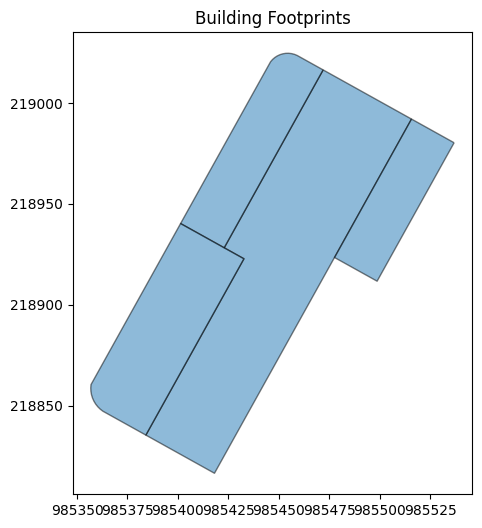

In [56]:
data = gdf_build_filter.loc[[42 ,  6435,  13766,  28830], :]
data.plot(figsize=(6, 6), edgecolor="black", alpha=0.5)
plt.title("Building Footprints")
plt.show()

In [103]:
energy = pd.read_csv('energy.csv')
energy = energy.rename(columns={'NYC Building Identification Number (BIN)': 'BIN',
                                'NYC Borough, Block and Lot (BBL)': 'BBL'})
energy.shape

(29842, 249)

In [105]:
energy['BIN'] = np.where(energy['BIN'].isin(['Not Available', '']), None, energy['BIN'])
energy['BIN'] = energy['BIN'].str.replace(":", " ")
energy['BIN'] = energy['BIN'].str.replace(",", " ")
energy['BIN'] = energy['BIN'].str.replace(";", " ")
energy['BIN'] = energy['BIN'].str.split()
energy = energy.explode('BIN').reset_index()
energy.shape

(47264, 251)

In [115]:
gdf_build_filter[gdf_build_filter['BIN'] == '1031627']

Empty GeoDataFrame
Columns: [level_0, index, the_geom, NAME, BIN, CNSTRCT_YR, LSTMODDATE, LSTSTATYPE, DOITT_ID, HEIGHTROOF, FEAT_CODE, GROUNDELEV, SHAPE_AREA, SHAPE_LEN, BASE_BBL, MPLUTO_BBL, GEOMSOURCE, GLOBALID]
Index: []

In [116]:
gdf_build_filter['BIN']

0        1062896.0
1        1039988.0
2        1026714.0
3        1086948.0
4        2004511.0
           ...    
61003    1038549.0
61004    1062863.0
61005    1053577.0
61006    1090409.0
61007    2128608.0
Name: BIN, Length: 61008, dtype: object

In [119]:
# gdf_build_filter['BIN'] = gdf_build_filter['BIN'].astype('int').astype('str') 
build_energy = gdf_build_filter.merge(energy, left_on='BIN', right_on='BIN', how='inner')

In [121]:
build_energy.SHAPE_AREA.describe()

count     13026.000000
mean      12687.545239
std       23993.891007
min         404.291653
25%        5470.673704
50%        7993.266879
75%       12188.262834
max      418673.048577
Name: SHAPE_AREA, dtype: float64

In [110]:
build_energy[~build_energy['Property Id'].isna()].shape

(0, 268)

In [78]:
gdf_build_filter[gdf_build_filter['MPLUTO_BBL'] == 1001420025]

Empty GeoDataFrame
Columns: [level_0, index, the_geom, NAME, BIN, CNSTRCT_YR, LSTMODDATE, LSTSTATYPE, DOITT_ID, HEIGHTROOF, FEAT_CODE, GROUNDELEV, SHAPE_AREA, SHAPE_LEN, BASE_BBL, MPLUTO_BBL, GEOMSOURCE, GLOBALID]
Index: []

In [70]:
gdf_build_filter[gdf_build_filter['BIN'] == 1083157]['MPLUTO_BBL'] == 1012060001

48625    True
Name: MPLUTO_BBL, dtype: bool

In [77]:
gdf_build_filter[gdf_build_filter['BIN'] == 1083241]

Empty GeoDataFrame
Columns: [level_0, index, the_geom, NAME, BIN, CNSTRCT_YR, LSTMODDATE, LSTSTATYPE, DOITT_ID, HEIGHTROOF, FEAT_CODE, GROUNDELEV, SHAPE_AREA, SHAPE_LEN, BASE_BBL, MPLUTO_BBL, GEOMSOURCE, GLOBALID]
Index: []

In [16]:
from rtree import index

gt = rasterio.transform.from_bounds(lower_left[1], lower_left[0], upper_right[1], upper_right[0], width, height)
proj_wgs84 = Proj(init='epsg:4326')
proj_utm = Proj(init='epsg:2263')
transformer = Transformer.from_proj(proj_wgs84, proj_utm, always_xy=True)

def overlap_building_area(raster_height, raster_width, gt, gdf_build):
    idx = index.Index()
    gdf = gdf_build.to_crs(epsg=2263)

    # Build the Rtree index for faster spatial queries
    for i, geometry in enumerate(gdf['the_geom']):
        idx.insert(i, geometry.bounds)  # Insert bounding boxes into the index

    area_raster = np.zeros((raster_height, raster_width), dtype=np.float32)  # Area layer

    for i in tqdm(range(raster_width)):
        for j in range(raster_height):
            # Get the bounds of the current raster cell (grid square)
            x_min, y_max = gt * (i, j)
            x_min, y_max = transformer.transform(x_min, y_max)
            x_max, y_min = gt * (i + 1, j + 1)
            x_max, y_min = transformer.transform(x_max, y_min)
            grid_cell = box(x_min, y_min, x_max, y_max)

            # Clip building footprints by the current grid cell
            possible_matches = list(idx.intersection(grid_cell.bounds))  # Find potential matches
            clipped_buildings = gdf.iloc[possible_matches] 

            # Calculate the area of the part of the building that falls within the grid cell
            total_area = 0
            for _, building in clipped_buildings.iterrows():
                intersection = building['the_geom'].intersection(grid_cell)  # Clip the building to the grid cell
                total_area += intersection.area  # Add the area of the intersection

            # Store the total area for the grid cell
            area_raster[j, i] = total_area 
    
    return area_raster

In [17]:
building_area_raster = overlap_building_area(height, width, gt, gdf_build_filter) * 0.092903
building_area_raster

100%|██████████| 1671/1671 [30:48<00:00,  1.11s/it]


array([[ 0.       ,  0.       ,  0.       , ..., 41.94274  , 24.985247 ,
        18.661182 ],
       [ 0.       ,  0.       ,  0.       , ...,  7.8021007, 47.595665 ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ..., 19.035551 ,  1.0118183,
         0.       ],
       ...,
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ]], shape=(1448, 1671), dtype=float32)

In [23]:
transformer = Transformer.from_proj(proj_utm, proj_wgs84, always_xy=True)

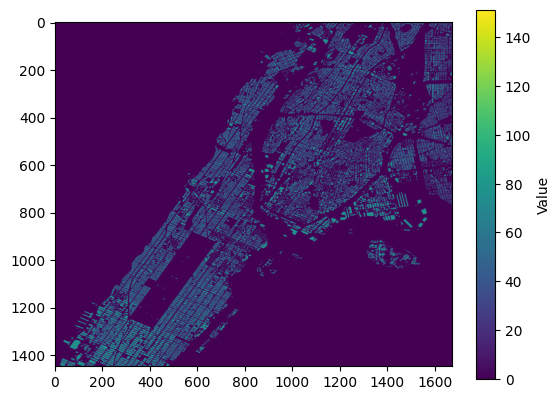

In [22]:
plt.imshow(building_area_raster, cmap="viridis")
plt.colorbar(label="Value")

##### Average building height

In [71]:
from scipy.stats import mode

def building_features(raster_height, raster_width, gt, gdf):
    idx = index.Index()

    # Build the Rtree index for faster spatial queries
    for i, geometry in enumerate(gdf['the_geom']):
        idx.insert(i, geometry.bounds)  # Insert bounding boxes into the index

    height_raster = np.zeros((raster_height, raster_width), dtype=np.float32)  # Height layer 
    year_raster = np.zeros((raster_height, raster_width), dtype=np.float32)
    type_raster = np.zeros((raster_height, raster_width), dtype=np.float32)

    for i in tqdm(range(raster_width)):
        for j in range(raster_height):
            # Get the bounds of the current raster cell (grid square)
            x_min, y_max = gt * (i, j)
            x_max, y_min = gt * (i + 1, j + 1)
            grid_cell = box(x_min, y_min, x_max, y_max)

            # Clip building footprints by the current grid cell
            possible_matches = list(idx.intersection(grid_cell.bounds))  # Find potential matches
            clipped_buildings = gdf.iloc[possible_matches] 

            # Calculate the area of the part of the building that falls within the grid cell
            total_height = 0
            total_year = 0
            build_type = []
            count = 0
            for _, building in clipped_buildings.iterrows():
                # intersection = building['the_geom'].intersection(grid_cell)
                total_height += building['HEIGHTROOF']
                total_year += building['CNSTRCT_YR']
                build_type.append(building['FEAT_CODE'])
                count += 1
                
            # Store the total area for the grid cell
            if count > 0:
                height_raster[j, i] = total_height / count
                year_raster[j, i] = total_year / count
                type_raster[j, i] = mode(build_type)[0]
            else:
                height_raster[j, i] = 0
                year_raster[j, i] = 0
                type_raster[j, i] = 0
    
    return height_raster, year_raster, type_raster

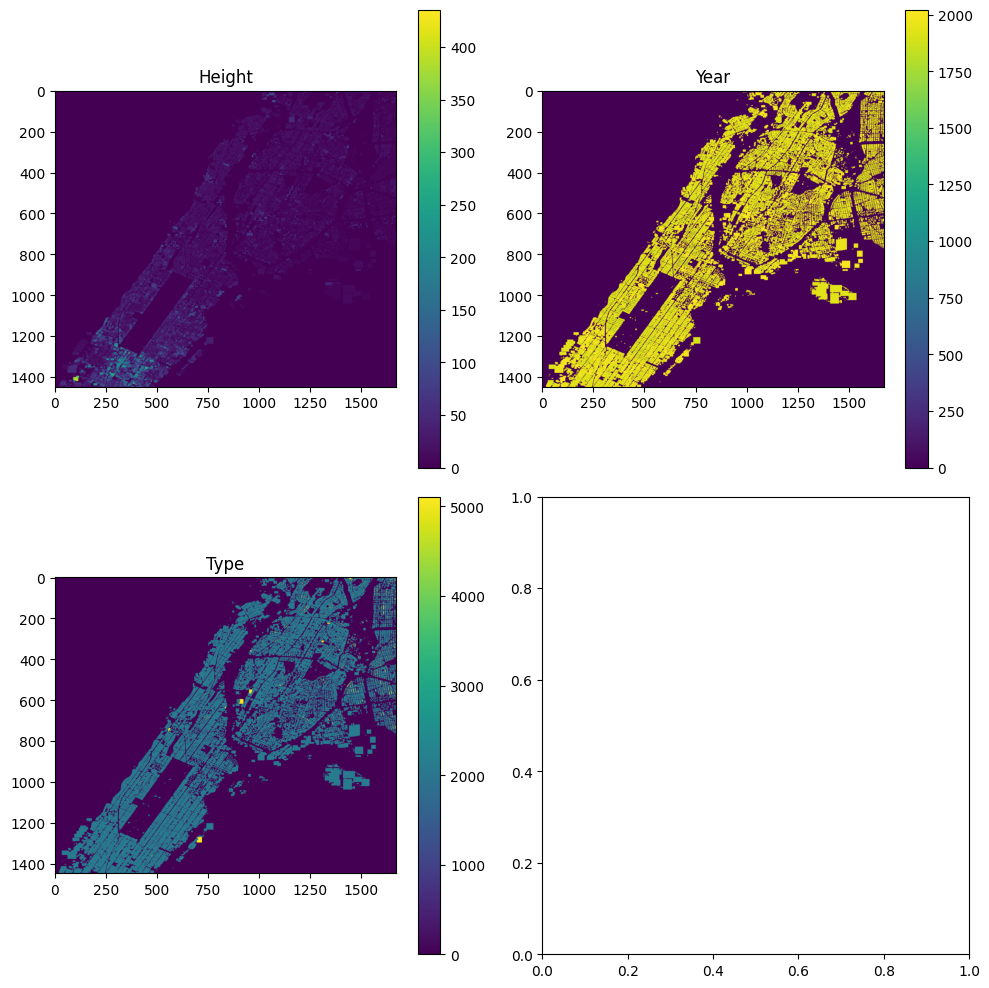

In [74]:
height_raster, year_raster, type_raster = building_features(height, width, gt, gdf_build_filter)
height_raster = height_raster / 3.280839895

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Flatten the axes for easier indexing
axes = axes.flatten()

im1 = axes[0].imshow(height_raster, cmap='viridis')
axes[0].set_title('Height')
fig.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(year_raster, cmap='viridis')
axes[1].set_title('Year')
fig.colorbar(im2, ax=axes[1])

im3 = axes[2].imshow(type_raster, cmap='viridis')                 
axes[2].set_title('Type')
fig.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.show()

In [78]:
with rasterio.open(
    'features_test/building.tiff', 'w', driver='GTiff', height=height, width=width,
    count=4, dtype=building_area_raster.dtype, crs=gdf_build_filter.crs, transform=gt
) as dst:
    dst.write(building_area_raster, 1)
    dst.write(height_raster, 2)
    dst.write(year_raster, 3)
    dst.write(type_raster, 4)

### Street

In [2]:
street_path = "nyclion_24d/lion/lion.gdb"
street_1 = gpd.read_file(f"{street_path}/a0000000c.gdbtable")
street_2 = gpd.read_file(f"{street_path}/a0000000d.gdbtable")

street_1 = street_1[~street_1['PDir'].isna() | ~street_1['SDir'].isna()]
gdf_street = street_2.merge(street_1, on='Join_ID', how='left')
gdf_street.head()

Street_x                     SAFStreetName FeatureTyp SegmentTyp  \
0  EAST 168 STREET                                            0          U   
1  WEST 192 STREET                                            0          U   
2     UNION AVENUE                                            0          U   
3     UNION AVENUE  BEHAGEN PLAYGROUND COMFORT STA            0          U   
4     UNION AVENUE  BEHAGEN PLAYGROUND FIELD NORTH            0          U   

  IncExFlag RB_Layer NonPed TrafDir TrafSrc SpecAddr  ... R_PD_Service_Area  \
0                  B              T     DOT           ...                     
1                  B              A     DOT           ...                     
2                  B              W     DOT           ...                     
3                  B              W     DOT        X  ...                     
4                  B              W     DOT        X  ...                     

  TRUCK_ROUTE_TYPE SHAPE_Length  \
0                    396.030947   
1                    279.360514   
2                    618.327133   
3                    618.327133   
4                    618.327133   

                                            geometry PDir PType SName SType  \
0  MULTILINESTRING ((1010964.447 241812.261, 1011...  NaN   NaN   NaN   NaN   
1  MULTILINESTRING ((1011576.687 255023.583, 1011...  NaN   NaN   NaN   NaN   
2  MULTILINESTRING ((1011600.676 239639.743, 1011...  NaN   NaN   NaN   NaN   
3  MULTILINESTRING ((1011600.676 239639.743, 1011...  NaN   NaN   NaN   NaN   
4  MULTILINESTRING ((1011600.676 239639.743, 1011...  NaN   NaN   NaN   NaN   

  SDir Street_y  
0  NaN      NaN  
1  NaN      NaN  
2  NaN      NaN  
3  NaN      NaN  
4  NaN      NaN  

[5 rows x 135 columns]

In [3]:
gdf_street.shape

(255581, 135)

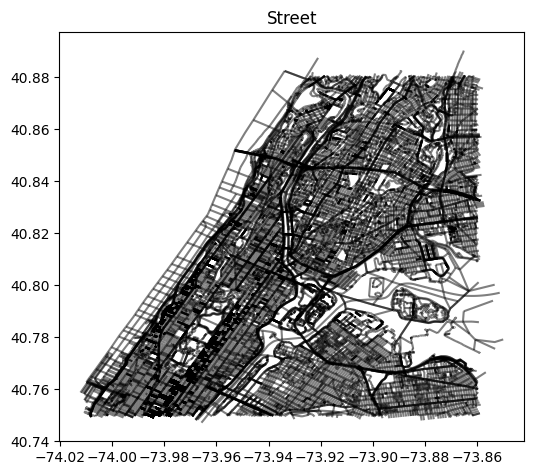

In [205]:
transformer = Transformer.from_crs("EPSG:2263", "EPSG:4326", always_xy=True)
def transform_geometry(geometry):
    return transform(lambda x, y: transformer.transform(x, y), geometry)
gdf_street['geometry'] = gdf_street['geometry'].apply(transform_geometry)

gdf_street = gdf_street.cx[lower_left[1]:upper_right[1], lower_left[0]:upper_right[0]]
gdf_street.plot(figsize=(6, 6), edgecolor="black", alpha=0.5)
plt.title("Street")
plt.show()

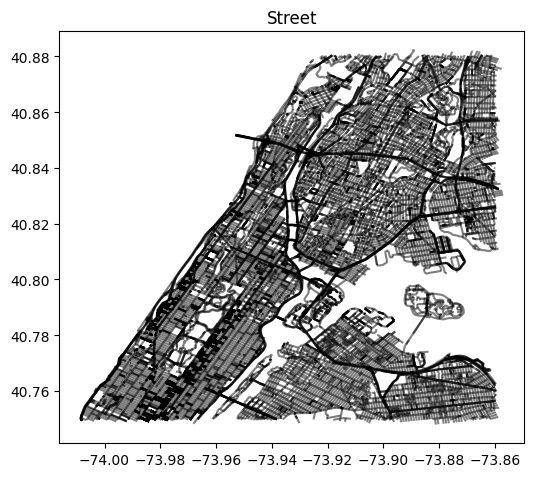

In [207]:
street_cond = (~gdf_street['FeatureTyp'].isin(['2', '5', '7', '9', 'F'])) \
        & (~gdf_street['RW_TYPE'].isin([' 4', '12', '14'])) \
        & (gdf_street['Status'] == "2") 
gdf_street_filter = gdf_street[street_cond]

gdf_street_filter.plot(figsize=(6, 6), edgecolor="black", alpha=0.5)
plt.title("Street")
plt.show()

In [208]:
# Use average street width

gdf_street_filter['avg_street_width'] = (gdf_street_filter['StreetWidth_Max'] + gdf_street_filter['StreetWidth_Min']) / 2
gdf_street_filter["avg_street_width"] = gdf_street_filter.groupby("RW_TYPE")["avg_street_width"].transform(lambda x: x.fillna(x.median()))

gdf_street_filter['RW_TYPE'] = gdf_street_filter['RW_TYPE'].astype('int')

In [209]:
transformer = Transformer.from_crs("EPSG:4326", "EPSG:2263", always_xy=True)
def transform_geometry(geometry):
    return transform(lambda x, y: transformer.transform(x, y), geometry)
gdf_street_filter['geometry'] = gdf_street_filter['geometry'].apply(transform_geometry)

In [210]:
gt = rasterio.transform.from_bounds(lower_left[1], lower_left[0], upper_right[1], upper_right[0], width, height)
proj_wgs84 = Proj(init='epsg:4326')
proj_utm = Proj(init='epsg:2263')
transformer = Transformer.from_proj(proj_wgs84, proj_utm, always_xy=True)

def street_features(raster_height, raster_width, gt, gdf):
    idx = index.Index()

    # Build the Rtree index for faster spatial queries
    for i, geometry in enumerate(gdf['geometry']):
        idx.insert(i, geometry.bounds)  # Insert bounding boxes into the index

    street_width_raster = np.zeros((raster_height, raster_width), dtype=np.float32)
    street_type_raster = np.zeros((raster_height, raster_width), dtype=np.int8)

    for i in tqdm(range(raster_width)):
        for j in range(raster_height):
            # Get the bounds of the current raster cell (grid square)
            x_min, y_max = gt * (i, j)
            x_min, y_max = transformer.transform(x_min, y_max)
            x_max, y_min = gt * (i + 1, j + 1)
            x_max, y_min = transformer.transform(x_max, y_min)
            grid_cell = box(x_min, y_min, x_max, y_max)

            # Clip building footprints by the current grid cell
            possible_matches = list(idx.intersection(grid_cell.bounds))  # Find potential matches
            clipped_streets = gdf.iloc[possible_matches] 

            # Calculate the area of the part of the building that falls within the grid cell
            total_width = 0
            street_type = []
            count = 0 
            for _, street in clipped_streets.iterrows():
                total_width += street['avg_street_width']
                street_type.append(street['RW_TYPE'])
                count += 1

            # Store the total area for the grid cell
            if count == 0:
                street_width_raster[j, i] = -1
                street_type_raster[j, i] = 0
            else:
                street_width_raster[j, i] = total_width / count
                street_type_raster[j, i] = mode(street_type)[0]
    
    return street_width_raster, street_type_raster

100%|██████████| 1671/1671 [50:27<00:00,  1.81s/it] 


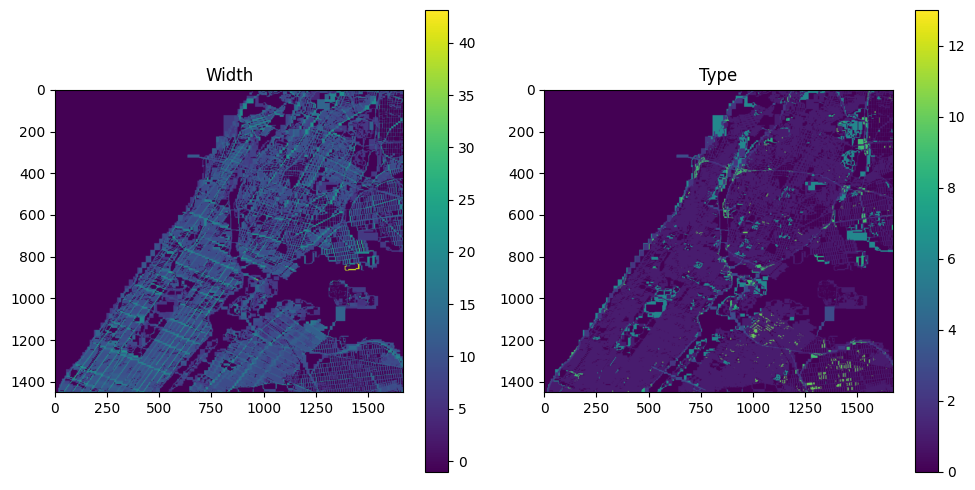

In [213]:
street_width_raster, street_type_raster = street_features(height, width, gt, gdf_street_filter)
street_width_raster = np.where(street_width_raster == -1, street_width_raster,  street_width_raster / 3.280839895)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Flatten the axes for easier indexing
axes = axes.flatten()

im1 = axes[0].imshow(street_width_raster, cmap='viridis')
axes[0].set_title('Width')
fig.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(street_type_raster, cmap='viridis')
axes[1].set_title('Type')
fig.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

In [214]:
with rasterio.open(
    'features_test/street_canyon.tiff', 'w', driver='GTiff', height=height, width=width,
    count=2, dtype=street_width_raster.dtype, crs=gdf_street_filter.crs, transform=gt
) as dst:
    dst.write(street_width_raster, 1)
    dst.write(street_type_raster, 2)